## 1. Variational Auto Encoder

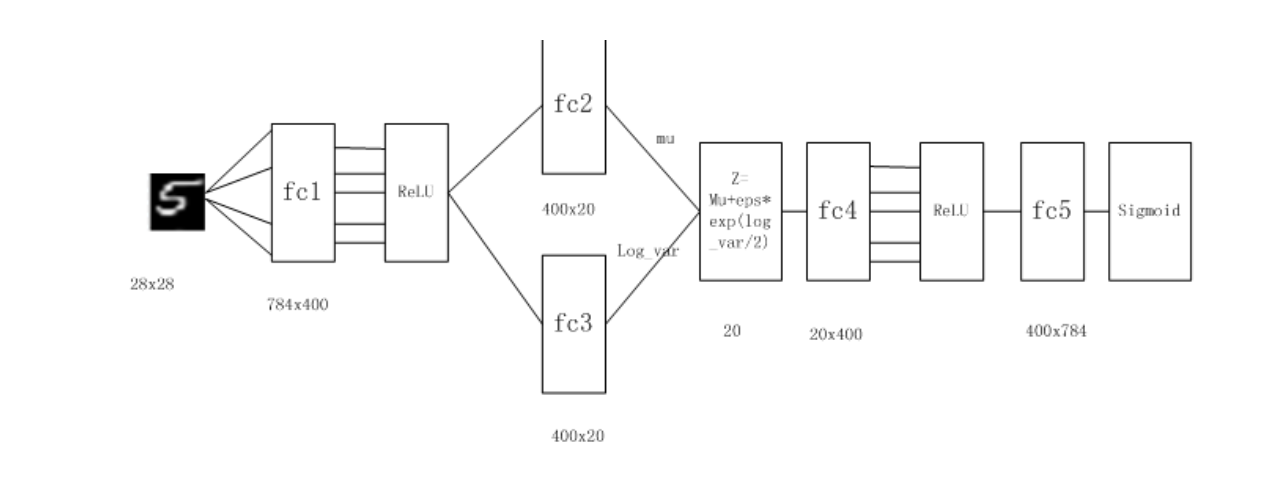

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 30
batch_size = 128
learning_rate = 0.001

In [6]:
# 下载MNIST训练集，这里因已下载，故download=False
# 如果需要下载，设置download=True将自动下载
dataset = torchvision.datasets.MNIST(root='data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=False)
 
#数据加载
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                            shuffle=True)

In [40]:
# 定义AVE模型
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    #用mu，log_var生成一个潜在空间点z，mu，log_var为两个统计参数，我们假设
    #这个假设分布能生成图像。
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std
 
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [41]:
# 设置pytorch在哪块GPU上运行，这里假设使用序号为1的这块GPU.
#torch.cuda.set_device(1)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [46]:
# l_hist = []
# ii = 0
# for epoch in range(1):
    
#     for x, y in data_loader:
#         ii += 1
#         if ii < len(data_loader):
#             out, mu, log_var = model(x.reshape(batch_size, image_size))

#             # 定义重构损失函数及KL散度
#             reconst_loss = F.binary_cross_entropy(out, x.reshape(batch_size, image_size), size_average=False)
#             kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#             #两者相加得总损失
#             loss= reconst_loss+ kl_div

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             l_hist.append(loss.data.numpy()) 

In [45]:
next(iter(data_loader))[0].shape, len(data_loader)

(torch.Size([128, 1, 28, 28]), 469)

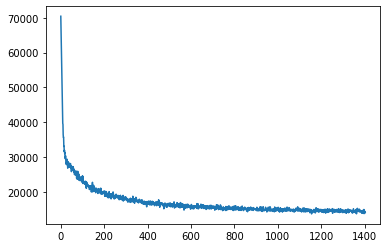

In [48]:
import matplotlib.pyplot as plt
plt.plot(range(len(l_hist)), l_hist)

In [ ]:
#开始训练模型
for epoch in range(num_epochs):
    model.train()
    for i, (x, _) in enumerate(data_loader):
        # 前向传播
        model.zero_grad()
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        #反向传播及优化器
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))

In [51]:
sample_dir = '/Users/tinggao/Downloads/'

with torch.no_grad():
    # 保存采样图像，即潜在向量Z通过解码器生成的新图像
    z = torch.randn(batch_size, z_dim).to(device)
    out = model.decode(z).view(-1, 1, 28, 28)
    save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(num_epochs+1)))

    # 保存重构图像，即原图像通过解码器生成的图像
    out, _, _ = model(x.reshape(-1, image_size))
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(num_epochs+1)))


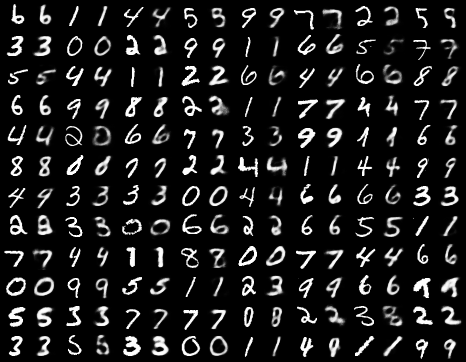

## 2. Generative Adversarial Nets (GAN)

In [58]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image


# 设备配置
#torch.cuda.set_device(1) # 这句用来设置pytorch在哪块GPU上运行，这里假设使用序号为1的这块GPU.
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 定义一些超参数
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 20
batch_size = 100
sample_dir = '/Users/tinggao/Downloads/gan_samples'

# 在当前目录，创建不存在的目录gan_samples
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
trans = transforms.Compose([
                transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])


# MNIST dataset
mnist = torchvision.datasets.MNIST(root='data',
                                   train=True,
                                   transform=trans,
                                   download=False)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [59]:
# 构建判断器
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# 构建生成器，这个相当于AVE中的解码器 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# 把判别器和生成器迁移到GPU上
D = D.to(device)
G = G.to(device)

# 定义判别器的损失函数交叉熵及优化器
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

#Clamp函数x限制在区间[min, max]内
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# 开始训练
total_step = len(data_loader)

In [60]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # 定义图像是真或假的标签
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      训练判别器                                    #
        # ================================================================== #

        # 定义判断器对真图片的损失函数
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 定义判别器对假图片（即由潜在空间点生成的图片）的损失函数
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs        
     
        # 得到判别器总的损失函数
        d_loss = d_loss_real + d_loss_fake
        
        # 对生成器、判别器的梯度清零        
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        训练生成器                                  #
        # ================================================================== #

        # 定义生成器对假图片的损失函数，这里我们要求
        #判别器生成的图片越来越像真图片，故损失函数中
        #的标签改为真图片的标签，即希望生成的假图片，
        #越来越靠近真图片
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        
        g_loss = criterion(outputs, real_labels)
        
        # 对生成器、判别器的梯度清零
        #进行反向传播及运行生成器的优化器
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # 保存真图片
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # 保存假图片
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# 保存模型
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/20], Step [200/600], d_loss: 0.0440, g_loss: 4.3973, D(x): 0.99, D(G(z)): 0.03
Epoch [0/20], Step [400/600], d_loss: 0.2609, g_loss: 4.9145, D(x): 0.91, D(G(z)): 0.08
Epoch [0/20], Step [600/600], d_loss: 0.0832, g_loss: 5.1860, D(x): 0.95, D(G(z)): 0.03
Epoch [1/20], Step [200/600], d_loss: 0.1723, g_loss: 4.9889, D(x): 0.96, D(G(z)): 0.11
Epoch [1/20], Step [400/600], d_loss: 0.1897, g_loss: 4.3346, D(x): 0.97, D(G(z)): 0.14
Epoch [1/20], Step [600/600], d_loss: 0.6613, g_loss: 1.9375, D(x): 0.79, D(G(z)): 0.23
Epoch [2/20], Step [200/600], d_loss: 0.1762, g_loss: 3.9555, D(x): 0.94, D(G(z)): 0.07
Epoch [2/20], Step [400/600], d_loss: 0.2655, g_loss: 4.7598, D(x): 0.92, D(G(z)): 0.11
Epoch [2/20], Step [600/600], d_loss: 0.4043, g_loss: 3.4106, D(x): 0.90, D(G(z)): 0.23
Epoch [3/20], Step [200/600], d_loss: 0.8371, g_loss: 3.2075, D(x): 0.80, D(G(z)): 0.27
Epoch [3/20], Step [400/600], d_loss: 0.1007, g_loss: 3.4297, D(x): 0.96, D(G(z)): 0.05
Epoch [3/20], Step [600/600], d_

In [62]:
# reconsPath = './gan_samples/real_images.png'
# Image = mpimg.imread(reconsPath)
# plt.imshow(Image) # 显示图片
# plt.axis('off') # 不显示坐标轴
# plt.show()

In [63]:
# reconsPath = './gan_samples/fake_images-200.png'
# Image = mpimg.imread(reconsPath)
# plt.imshow(Image) # 显示图片
# plt.axis('off') # 不显示坐标轴
# plt.show()